In [ ]:
!pip install mne-icalabel
!pip install mne

In [ ]:
import numpy as np
import pandas as pd
import mne
from mne_icalabel import label_components

In [2]:
ch_names = ['P4','O2','P8','T8','C4','Cz','Fz','F4','Fp2','F8','Fp1','F7','F3','C3','T7','P7','P3','O1','Pz'];
sfreq = 250;
# create info instance to create eeg mne object
eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg', verbose=None);

#path to eeg
path = r"C:\Users\L03509242\Downloads\data_porn_addiction\S6\EO.csv";
eeg_pandas = pd.read_csv(path, delimiter=";");
eeg_pandas=eeg_pandas.transpose();

#create eeg object
eeg_raw = mne.io.RawArray(eeg_pandas, eeg_info);

# Use the preloaded montage for the 10-20 system.
montage_1020 = mne.channels.make_standard_montage("standard_1020",head_size='auto');
eeg_raw.set_montage(montage_1020);

# filter to remove slow drift, and be able to comply with the label_components
# sepcifications for input, per 
# https://github.com/mne-tools/mne-icalabel/blob/main/examples/00_iclabel.py

filt_raw = eeg_raw.copy().filter(l_freq=1.0, h_freq=100.0)

# Before fitting ICA, we will apply a common average referencing, to comply
# with the ICLabel requirements.

filt_raw = filt_raw.set_eeg_reference("average")

# fig = eeg_raw.plot_sensors(show_names=True)
# mne.viz.plot_raw(eeg, scalings = 'auto')

Creating RawArray with float64 data, n_channels=19, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


In [11]:
# look into what the fit_params argument does
ica = mne.preprocessing.ICA(n_components=None, max_iter="auto", random_state=97,method='infomax', fit_params=dict(extended=True));

ica.fit(filt_raw);
# ica

ic_labels = label_components(filt_raw, ica, method="iclabel");
# We can extract the labels of each component and exclude
# non-brain classified components, keeping 'brain' and 'other'.
# "Other" is a catch-all that for non-classifiable components.
# We will stay on the side of caution and assume we cannot blindly remove these.

labels = ic_labels["labels"];
exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(f"Excluding these ICA components: {exclude_idx}")

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Computing Extended Infomax ICA
Fitting ICA took 5.4s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Excluding these ICA components: [1, 2]


In [13]:
# %%
# Now that the exclusions have been set, we can reconstruct the sensor signals
# with artifacts removed using the `~mne.preprocessing.ICA.apply` method
# (remember, we're applying the ICA solution from the *filtered* data to the
# original *unfiltered* signal). Plotting the original raw data alongside the
# reconstructed data shows that the heartbeat and blink artifacts are repaired.

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = eeg_raw.copy();
ica.apply(reconst_raw, exclude=exclude_idx);

Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


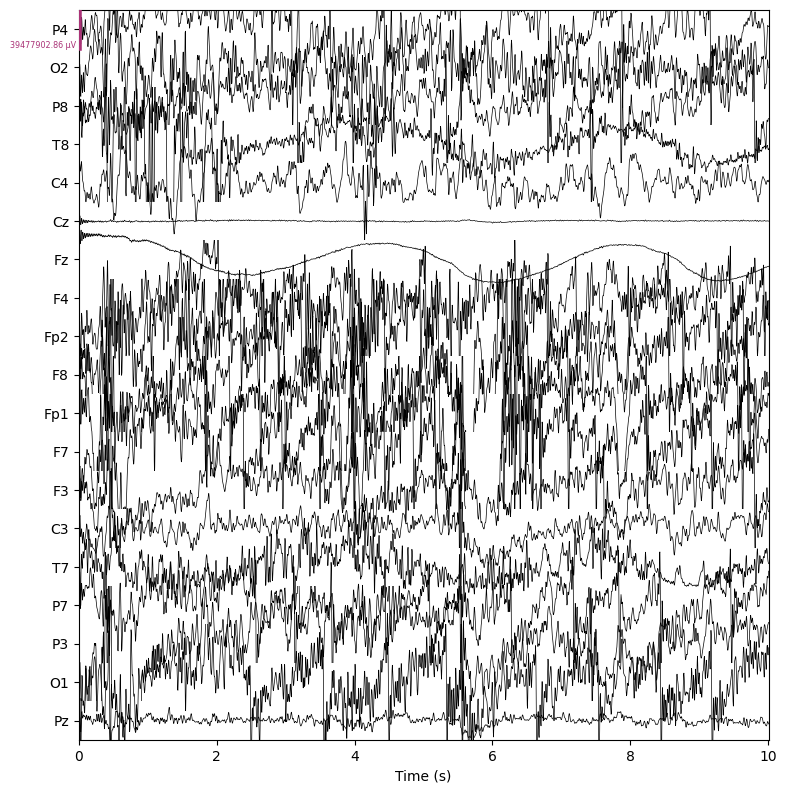

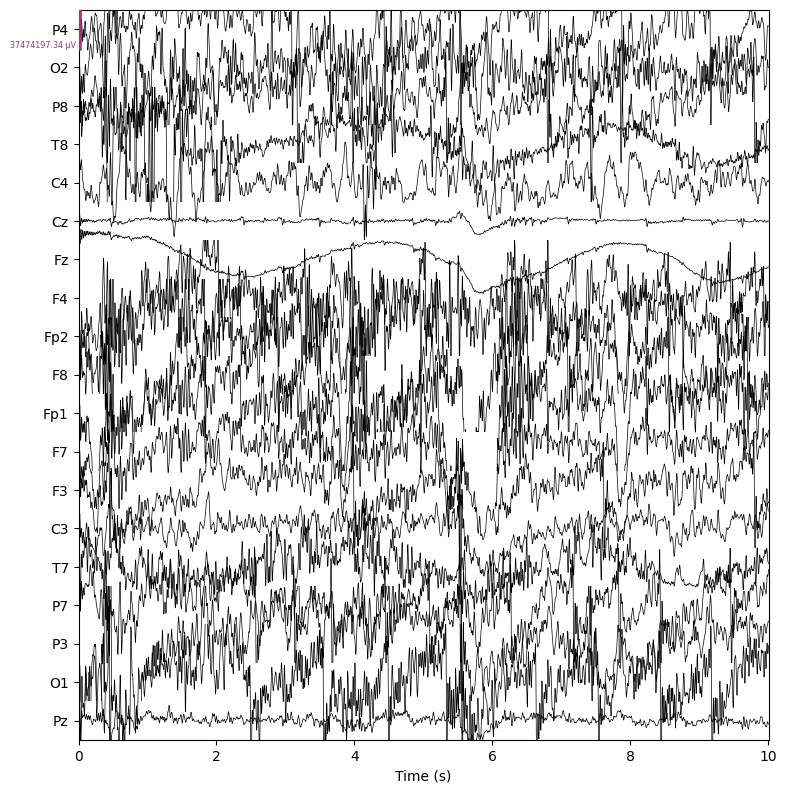

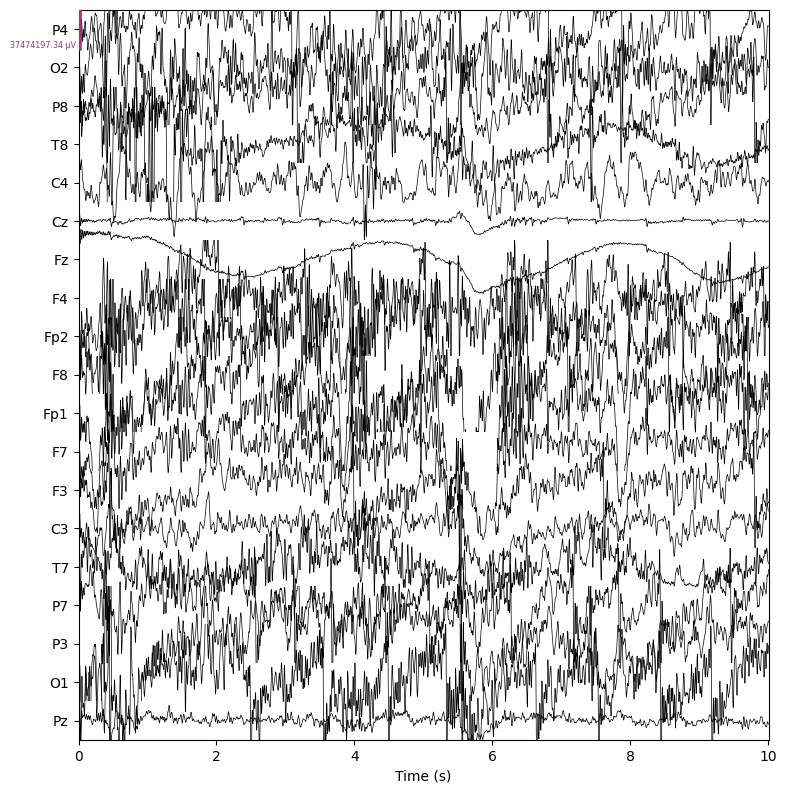

In [17]:
#ica.plot_sources(eeg_raw)
#ica.plot_components()

eeg_raw.plot(show_scrollbars=False,scalings = 'auto')
reconst_raw.plot(show_scrollbars=False,scalings = 'auto')

In [4]:
mne.channels.make_standard_montage("standard_1020",head_size='auto')

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>

In [37]:
eeg_raw._data.shape

(19, 15000)